In [2]:
import pandas as pd
import nilmtk
import matplotlib.pyplot as plt
import random
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import h5py
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.datastore import HDFDataStore
from matplotlib import rcParams
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
import tensorflow as tf
from tensorflow import keras
from Lstm import RNNDisaggregator
import time
import metrics

2023-04-30 22:53:29.885338: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
print("========== OPEN DATASETS ============")
train_house02 = DataSet('/root/autodl-tmp/redd_low_new.h5')
train_house03 = DataSet('/root/autodl-tmp/redd_low_new.h5')
train_house02.set_window(end="5-2-2011")
train_house03.set_window(end="28-4-2011")

val = DataSet('/root/autodl-tmp/redd_low_new.h5')
val.set_window(start="16-5-2011")

test = DataSet('/root/autodl-tmp/redd_low_new.h5')
test.set_window(end="5-3-2011")

train_building = [2,3]
val_building = 1
test_building = 1
sample_period = 3
meter_key = 'fridge'

train_mains = []
train_mains.append(train_house02.buildings[train_building[0]].elec.mains().all_meters()[1])
train_mains.append(train_house03.buildings[train_building[1]].elec.mains().all_meters()[0])
# train_mains.append(train.buildings[train_building[2]].elec.mains().all_meters()[0])

train_meters = []
train_meters.append(train_house02.buildings[train_building[0]].elec.submeters()[meter_key])
train_meters.append(train_house03.buildings[train_building[1]].elec.submeters()[meter_key])


test_mains = test.buildings[test_building].elec.mains().all_meters()[0]
test_meters = test.buildings[test_building].elec.submeters()[meter_key]

val_mains = val.buildings[val_building].elec.mains().all_meters()[0]
val_meters = val.buildings[val_building].elec.submeters()[meter_key]

rnn = RNNDisaggregator(window_size=20)

========== OPEN DATASETS ============


2023-04-30 22:53:32.637249: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-30 22:53:32.702515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:a4:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2023-04-30 22:53:32.702584: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-30 22:53:32.706757: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-30 22:53:32.706825: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-30 22:53:32.707904: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 16)            80        
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           148480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,264,977
Trainable params: 1,264,977
Non-trainable params: 0
______________________________________________

In [3]:
start = time.time()
print("========== TRAIN ============")

history01 = rnn.train(train_mains[0], train_meters[0], epochs=10,sample_period=sample_period)
history02 = rnn.train(train_mains[1], train_meters[1], epochs=10,sample_period=sample_period)
rnn.export_model("model_CNNLSTM_lr0.01.h5")

end = time.time()
print("Train =", end-start, "seconds.")

========== TRAIN ============
(400241, 20, 1)
(400241,)
356.2344
84.37994
219.84592
61.480576
256
Epoch 1/10


2023-04-29 10:21:05.911110: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-29 10:21:05.931724: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2600000000 Hz
2023-04-29 10:21:09.224577: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-29 10:21:09.845781: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2023-04-29 10:21:10.595933: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-29 10:21:11.134927: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-29 10:21:11.354277: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1408/1408 [==============================] - 25s 14ms/step - loss: 0.2933 - val_loss: 0.3326
Epoch 2/10
1408/1408 [==============================] - 19s 13ms/step - loss: 0.2524 - val_loss: 0.2633
Epoch 3/10
1408/1408 [==============================] - 19s 13ms/step - loss: 0.2131 - val_loss: 0.2483
Epoch 4/10
1408/1408 [==============================] - 19s 13ms/step - loss: 0.2273 - val_loss: 0.3649
Epoch 5/10
1408/1408 [==============================] - 19s 13ms/step - loss: 0.2224 - val_loss: 0.2305
Epoch 6/10
1408/1408 [==============================] - 18s 13ms/step - loss: 0.2406 - val_loss: 0.2771
Epoch 7/10
1408/1408 [==============================] - 19s 13ms/step - loss: 0.2231 - val_loss: 0.2854
Epoch 8/10
1408/1408 [==============================] - 19s 13ms/step - loss: 0.2133 - val_loss: 0.3913
Epoch 9/10
1408/1408 [==============================] - 19s 13ms/step - loss: 0.2179 - val_loss: 0.2426
Epoch 10/10
1408/1408 [==============================] - 19s 13ms/step - lo

In [4]:
print("========== DISAGGREGATE ============")
disag_filename = 'disag_CNN-BiLSTM-lr0.01.h5'
output = HDFDataStore(disag_filename, 'w')
rnn.disaggregate(test_mains, output, train_meters[0], sample_period=sample_period)
output.close()

========== DISAGGREGATE ============
New sensible chunk: 5533
New sensible chunk: 26611
New sensible chunk: 7822
New sensible chunk: 6689
New sensible chunk: 653
New sensible chunk: 29766
New sensible chunk: 13757
New sensible chunk: 32510
New sensible chunk: 34806
New sensible chunk: 20284
New sensible chunk: 64862
New sensible chunk: 525
New sensible chunk: 31931
New sensible chunk: 41483
New sensible chunk: 37554
New sensible chunk: 8252


========== Plot ============


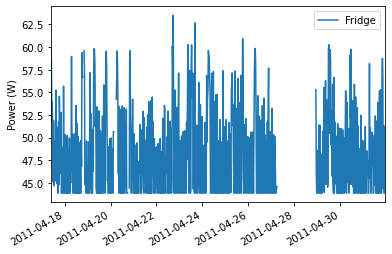

In [5]:
result = DataSet(disag_filename)
res_elec = result.buildings[test_building].elec

print("========== Plot ============")

predicted = res_elec[meter_key]
ground_truth = test_meters
import matplotlib.pyplot as plt
predicted.plot()
# ground_truth.plot()
# ground_truth.plot(timeframe=good_sections_pre[2])
# ground_truth.plot(timeframe=good_sections_pre[0])
plt.show()

In [6]:
good_sections_pre = predicted.good_sections()
good_sections_pre

[TimeFrame(start='2011-04-18 09:23:06-04:00', end='2011-04-18 13:58:45-04:00', empty=False),
 TimeFrame(start='2011-04-18 14:04:03-04:00', end='2011-04-19 12:13:36-04:00', empty=False),
 TimeFrame(start='2011-04-19 12:15:12-04:00', end='2011-04-19 18:45:18-04:00', empty=False),
 TimeFrame(start='2011-04-19 20:21:03-04:00', end='2011-04-20 01:54:30-04:00', empty=False),
 TimeFrame(start='2011-04-20 01:56:33-04:00', end='2011-04-20 02:28:12-04:00', empty=False),
 TimeFrame(start='2011-04-20 02:29:48-04:00', end='2011-04-21 03:17:06-04:00', empty=False),
 TimeFrame(start='2011-04-21 06:18:12-04:00', end='2011-04-21 17:45:03-04:00', empty=False),
 TimeFrame(start='2011-04-21 19:42:24-04:00', end='2011-04-22 22:46:54-04:00', empty=False),
 TimeFrame(start='2011-04-22 22:49:30-04:00', end='2011-04-24 03:48:48-04:00', empty=False),
 TimeFrame(start='2011-04-24 03:53:21-04:00', end='2011-04-24 20:46:33-04:00', empty=False),
 TimeFrame(start='2011-04-24 20:48:12-04:00', end='2011-04-27 02:50:18

In [7]:
ground_truth

ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])

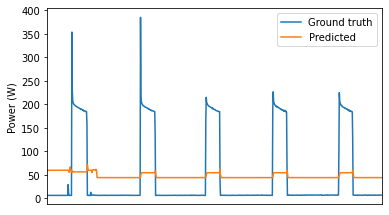

In [8]:
ground_truth.plot(timeframe=good_sections_pre[3])
predicted.plot(timeframe=good_sections_pre[3])
plt.legend(['Ground truth', 'Predicted'])
plt.show()

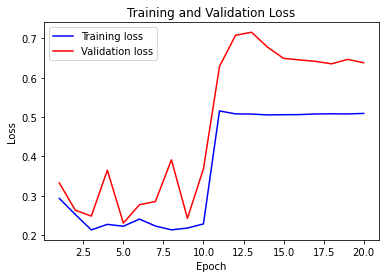

In [9]:
# Combine the history
history = {}
history['loss'] = history01['loss'] + history02['loss']
history['val_loss'] = history01['val_loss'] + history02['val_loss']

# Plot the loss curve
epochs = range(1, len(history['loss']) + 1)
plt.plot(epochs, history['loss'], 'b', label='Training loss')
plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
print("========== RESULTS ============")
result = DataSet('disag_CNN-BiLSTM-lr0.01.h5')
res_elec = result.buildings[test_building].elec
rpaf = metrics.recall_precision_accuracy_f1(res_elec[meter_key], test_meters)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(res_elec[meter_key], test_meters)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(res_elec[meter_key], test_meters)))

========== RESULTS ============
============ Recall: 1.0
============ Precision: 0.41510370286640624
============ Accuracy: 0.41510370286640624
============ F1 Score: 0.5866760181965185
============ Relative error in total energy: 0.12232645284506674
============ Mean absolute error(in Watts): 61.04004296664392
